# Classification detection V3

Use of **Transfer learning** for extraction of features along with feature map

In [2]:
!nvidia-smi

Sun Apr  4 18:06:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import numpy as np
import cv2
from tqdm.notebook import tqdm

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

## Building the model

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K

In [ ]:
def build_model(optimizer, learning_rate, number_of_categories):

    model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling = 'average')
    model.trainable = False

    mapping_layer = keras.layers.Conv2DTranspose(16, (3,3))(model.output)
    mapping_layer = keras.layers.Conv2DTranspose(1, (3,3))(mapping_layer)
    
    y_out = keras.layers.Flatten()(mapping_layer)
    y_out = keras.layers.Dense(number_of_categories, activation='softmax')(y_out)

    final_model = keras.models.Model(inputs=[model.input],
                                     outputs=[y_out])

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True )
    if optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    final_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=['accuracy','AUC'])

    return final_model


In [ ]:
model = build_model("SGD", 1e-3)
model.summary()

TypeError: ignored

## 1. METAL SURFACE DATA

The dataset was downloaded from [here](https://www.kaggle.com/fantacher/neu-metal-surface-defects-data).

Extract the zip folder and rename the inside folder to `'metal_surface_dataset'`

### Preprocessing the dataset

In [ ]:
import os
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt

dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
dataset = os.path.join(dataset_dir, 'metal_surface_products')

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.9,1.0],
                            zoom_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=1.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )


In [ ]:
batch_size = 16

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True) 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True) 

In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}
print(attribute_to_idx)

number_of_attributes = len(attribute_to_idx)
print(number_of_attributes)

In [ ]:
model = build_model("SGD", 1e-4, number_of_attributes)
model.summary()

### Training the model

In [ ]:
epochs = 20

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, min_lr = 1e-9, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs= epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr]) 

In [ ]:
model.save(os.path.join(model_dir, 'metal_surface_V1.h5'))

In [ ]:
import matplotlib.pyplot as plt

print("loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print("accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

print("auc")
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()

print("lr")
plt.plot(history.history['lr'])
plt.show()

### Testing the model

In [3]:
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(dataset_dir, 'metal_surface_products')

In [9]:
model1 = keras.models.load_model(os.path.join(model_dir, 'metal_surface_V1.h5'))
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
batch_size = 16

generator = keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.9,1.0],
                            zoom_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=1.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )

test_generator1 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical') 

Found 72 images belonging to 6 classes.


In [11]:
attribute_to_idx = test_generator1.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

{'Crazing': 0, 'Inclusion': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}
{0: 'Crazing', 1: 'Inclusion', 2: 'Patches', 3: 'Pitted', 4: 'Rolled', 5: 'Scratches'}


In [13]:
scores = model1.evaluate_generator(test_generator1, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""
20 eps

loss : 0.04393177479505539
accuracy : 1.0
auc : 1.0

"""

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


5/5 [==============================] - 55s 6s/step - loss: 0.0598 - accuracy: 1.0000 - auc: 1.0000
loss : 0.059793949127197266
accuracy : 1.0
auc : 1.0


'\n20 eps\n\nloss : 0.04393177479505539\naccuracy : 1.0\nauc : 1.0\n\n'

#### Visualise test results

In [ ]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator1):

    if idx == 1:
        break

    for i in range(batch_size):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model1.predict(np.expand_dims(image, axis=0))[0]

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds,axis=0)

        confidence = preds[predicted_value] * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])

    
    idx += 1

#### Get Activation maps

In [15]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer, classifier_layer
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = keras.layers.Flatten()(classifier_input)
    x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)


    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        #last_conv_layer_output = tf.reshape(last_conv_layer_output,[1,-1])
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer = model1.layers[-3]
classifier_layer = model1.layers[-1]

for idx, (images, output) in enumerate(test_generator1):

    if idx == 1:
        break

    for i in range(images.shape[0]):
        img = images[i] * 255

        image = np.expand_dims(images[i], axis=0)

        preds = model1.predict(image, verbose=1)[0]

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds, axis=0)

        confidence = preds[predicted_value] * 100
       
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            image, model1, last_conv_layer, classifier_layer
        )


        # We rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.6 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        plt.figure(figsize=(5,5))
        plt.imshow(superimposed_img)
        plt.show()

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
        
    idx += 1

## 2. CIVIL SURFACE CRACK DATA

### Pre-processing the dataset

In [ ]:
import os
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib as mplot

dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
filename = 'civil_surface_defect_dataset.tar.xz'
tar_file = os.path.join(dataset_dir, filename)

my_tar = tarfile.open(tar_file)
my_tar.extractall(dataset_dir) # specify which folder to extract to
my_tar.close()

In [ ]:
dataset = os.path.join(dataset_dir, 'civil_surface_defect_dataset')

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=5,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.8,1.0],
                            zoom_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=255.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float64',
                        )


In [ ]:
batch_size = 16

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='training',
                                                shuffle=True) 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='validation',
                                                shuffle=True) 


In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

number_of_attributes = len(attribute_to_idx)
attribute_to_idx

In [ ]:
a = next(train_generator)

for img in a[0][:5]:
    plt.imshow(img)
    plt.show()

### Building the model

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K

In [ ]:
def build_model(optimizer, learning_rate):

    model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling = 'average')
    model.trainable = False

    mapping_layer = keras.layers.Conv2DTranspose(16, (3,3))(model.output)
    mapping_layer = keras.layers.Conv2DTranspose(1, (3,3))(mapping_layer)
    mapping_layer = keras.layers.Activation("sigmoid")(mapping_layer)

    y_out = keras.layers.GlobalMaxPooling2D()(mapping_layer)

    final_model = keras.models.Model(inputs=[model.input],
                                     outputs=[y_out])

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True )
    if optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    final_model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy','AUC'])

    return final_model


In [ ]:
model = build_model("SGD", 1e-4)
model.summary()

### Training the model

In [ ]:
epochs = 20

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, min_lr = 1e-7, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs= epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr]) 

In [ ]:
model.save(os.path.join(model_dir, 'civil_surface_V2(20eps).h5'))

In [ ]:
import matplotlib.pyplot as plt

print("loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print("accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

print("auc")
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()

print("lr")
plt.plot(history.history['lr'])
plt.show()

### Testing the model

In [18]:
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(dataset_dir, 'civil_surface_defect_dataset')

In [19]:
model2 = keras.models.load_model(os.path.join(model_dir, 'civil_surface_V2(20eps).h5'))
model2.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
batch_size = 32

generator = keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=5,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.8,1.0],
                            zoom_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=255.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float64',
                        )

test_generator2 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary') 

Found 100 images belonging to 2 classes.


In [21]:
attribute_to_idx = test_generator2.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

In [22]:
scores = model2.evaluate_generator(test_generator2, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""
V2 - 20 eps
loss : 0.2489970624446869
accuracy : 0.9900000190734863
auc : 0.9999999403953552

"""

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


4/4 [==============================] - 46s 14s/step - loss: 0.2550 - accuracy: 0.9900 - auc: 1.0000
loss : 0.2549605071544647
accuracy : 0.9900000095367432
auc : 0.9999999403953552


'\nV2 - 20 eps\nloss : 0.2489970624446869\naccuracy : 0.9800000190734863\nauc : 0.9999999403953552\n\n'

#### Visualize test results

In [ ]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator2):

    if idx == 1:
        break

    for i in range(images.shape[0]):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model2.predict(np.expand_dims(image, axis=0))[0][0]

        actual_value = output[i]

        predicted_value = (preds > 0.75).astype(np.int)

        if predicted_value == 0:

            confidence = (1- preds) * 100
        else:
            confidence = preds * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
    idx += 1

#### Visualise detection results

In [24]:
batch_size = 1

test_generator2 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical') 
disp_images = []

pos_idx = 0
neg_idx = 0

for image, actual in test_generator2:

    output = np.argmax(actual, axis=1)[0]

    if output == 0 and pos_idx < 3:
        pos_idx += 1
        disp_images.append(image[0, ...])

    
    if output == 1 and neg_idx <3:
        neg_idx += 1
        disp_images.append(image[0, ...])

    if neg_idx>=3 and pos_idx>=3:
        break

disp_images = np.array(disp_images)
print(disp_images.shape)

Found 100 images belonging to 2 classes.
(6, 224, 224, 3)


In [25]:
import matplotlib as mplot

def plot_maps(images, maps, k, dims):
    map_size=dims[0]
    r_size = dims[1]
    r_stride = dims[2]
    colors = ['#ff0000', '#ff0080', '#ff00ff', '#8000ff', '#0080ff', '#00ffff', '#00ff80']
              
    fig, ax = plt.subplots(2, 3, figsize=(20,15))
    for j , (img, mask) in enumerate(zip(images, maps)):
        mask = mask.flatten()
        j_a = (j-j%3)//3
        j_b = j%3
        img = np.asarray(img[:,:,0],dtype=np.float32)/255
        ax[j_a][j_b].imshow(img,cmap=plt.get_cmap('gray'))
        
        for i in range(k):
            a_max = np.argmax(mask)
            x_region = a_max%map_size#note, numpy addresses work on arr[y, x, z], compared to image coordinates
            y_region = (a_max-(a_max%map_size))//map_size
            prob = mask[a_max]
       
            if prob<0.5:break
            x_pixel = r_stride*(x_region)
            y_pixel = r_stride*(y_region)
       
            #rectangle expects bottom left coordinates. We've generated Top Right
            rectangle = mplot.patches.Rectangle((x_pixel, y_pixel), r_size, r_size, edgecolor=colors[i-1],facecolor="none")
            ax[j_a][j_b].add_patch(rectangle)
            
            font = {'color':colors[i-1]}
            ax[j_a][j_b].text(x_pixel,y_pixel,s="{0:.3f}".format(prob), fontdict=font)
            
            mask[a_max]= 0#to help get the next most maximum
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
map_model = keras.models.Model(inputs=[model2.input], 
                               outputs=[model2.layers[-2].output])

final_layer = model2.layers[-1]

pred_maps = map_model.predict(disp_images)

plot_maps(disp_images, pred_maps, 5,  (11, 32, 21 ))

## 3. CASTING DATA

### Pre-processing


In [ ]:
import os
import tarfile
import shutil
import numpy as np
from tqdm.notebook import tqdm
import random
import keras
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
dataset = os.path.join(dataset_dir, 'casting_dataset_balanced')

In [ ]:
for category in os.listdir(dataset + '/train'):
    print(category, ":", len(os.listdir(os.path.join(dataset + '/train', category))))

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.2,
                            dtype='float32',
                        )


In [ ]:
batch_size = 32

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='training',
                                                shuffle=True) 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='validation',
                                                shuffle=True) 


In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)


### Building the model

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K

In [ ]:

def build_model(optimizer, learning_rate):

    model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling = 'average')
    model.trainable = False

    mapping_layer = keras.layers.Conv2DTranspose(16, (3,3))(model.output)
    mapping_layer = keras.layers.Conv2DTranspose(1, (3,3))(mapping_layer)
    mapping_layer = keras.layers.Activation("sigmoid")(mapping_layer)

    y_out = keras.layers.GlobalMaxPooling2D()(mapping_layer)

    final_model = keras.models.Model(inputs=[model.input],
                                     outputs=[y_out])

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True )
    if optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    final_model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy','AUC'])

    return final_model


In [ ]:
model = build_model("SGD", 1e-3)
model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model_1024"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_513 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_513[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

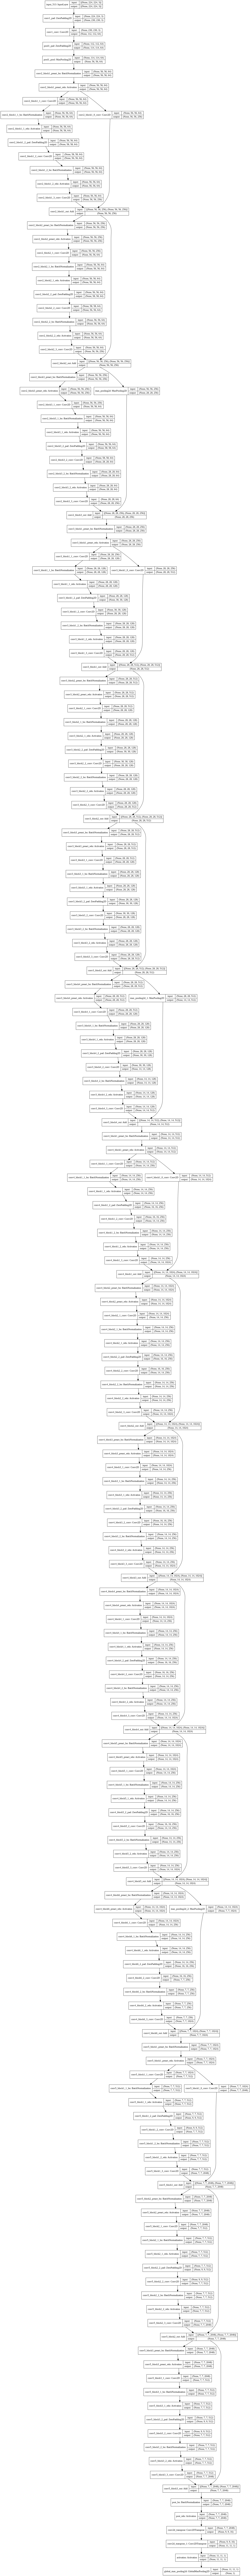

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Training model

In [ ]:
epochs = 100

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr = 1e-7, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs= epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr]) 

In [ ]:
model.save(os.path.join(model_dir, 'casting_V2( eps).h5'))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['lr'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()

### Testing the model

In [27]:
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(dataset_dir, 'casting_dataset_balanced')

In [28]:
model3 = keras.models.load_model(os.path.join(model_dir, 'casting_V2(100 eps).h5'))
model3.summary()

Model: "model_521"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_266 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_266[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
__________________________________________________________________________________________

In [29]:
batch_size = 32

generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.2,
                            dtype='float32',
                        )

test_generator3 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary') 

Found 734 images belonging to 2 classes.


In [30]:
attribute_to_idx = test_generator3.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)


{'def_front': 0, 'ok_front': 1}
{0: 'def_front', 1: 'ok_front'}


In [ ]:
scores = model3.evaluate_generator(test_generator3, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""
V1 - 50 eps

loss : 0.2496185153722763
accuracy : 0.9482288956642151
auc : 0.9841052293777466

V2 - 100 eps
loss : 0.07995594292879105
accuracy : 0.972752034664154
auc : 0.9960728287696838

"""

#### Visualise the results

In [32]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator3):

    if idx == 1:
        break

    for i in range(images.shape[0]):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model3.predict(np.expand_dims(image, axis=0))[0][0]

        actual_value = output[i]

        predicted_value = 1.0 if preds>0.6 else 0.0

        if predicted_value == 1.0:
            confidence = preds * 100
        else:
            confidence = (1 - preds) * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
    idx += 1

#### Visualise detection results

In [33]:
batch_size = 1

generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            dtype='float64',
                        )

test_generator3 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary') 
disp_images = []

pos_idx = 0
neg_idx = 0

for image, actual in test_generator3:

    output = int(actual[0])

    if output == 0 and pos_idx < 3:
        pos_idx += 1
        disp_images.append(image[0, ...])

    
    if output == 1 and neg_idx <3:
        neg_idx += 1
        disp_images.append(image[0, ...])

    if neg_idx>=3 and pos_idx>=3:
        break

disp_images = np.array(disp_images)
print(disp_images.shape)

Found 734 images belonging to 2 classes.
(6, 224, 224, 3)


In [34]:
def plot_maps(images, maps, k, dims):
    map_size=dims[0]
    r_size = dims[1]
    r_stride = dims[2]
    colors = ['#ff0000', '#ff0080', '#ff00ff', '#8000ff', '#0080ff', '#00ffff', '#00aa80', '#bb0080',  '#cc0080', '#dd0080',]
              
    fig, ax = plt.subplots(2, 3, figsize=(20,15))
    for j , (img, mask) in enumerate(zip(images, maps)):
        mask = mask.flatten()
        j_a = (j-j%3)//3
        j_b = j%3
        img = np.asarray(img[:,:,0],dtype=np.float32)
        ax[j_a][j_b].imshow(img,cmap=plt.get_cmap('gray'))
        
        for i in range(k):
            a_max = np.argmax(mask)
            x_region = a_max%map_size#note, numpy addresses work on arr[y, x, z], compared to image coordinates
            y_region = (a_max-(a_max%map_size))//map_size
            prob = mask[a_max]
       
            if prob>0.7:break
            x_pixel = r_stride*(x_region)
            y_pixel = r_stride*(y_region)
       
            #rectangle expects bottom left coordinates. We've generated Top Right
            rectangle = mplot.patches.Rectangle((x_pixel, y_pixel), r_size, r_size, edgecolor=colors[i-1],facecolor="none")
            ax[j_a][j_b].add_patch(rectangle)
            
            font = {'color':colors[i-1]}
            ax[j_a][j_b].text(x_pixel,y_pixel,s="{0:.3f}".format(1 - prob), fontdict=font)
            
            mask[a_max]= 0#to help get the next most maximum
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
map_model = keras.models.Model(inputs=[model3.input], 
                               outputs=[model3.layers[-2].output])

final_layer = model3.layers[-1]

pred_maps = map_model.predict(disp_images)

plot_maps(disp_images, pred_maps, 3,  (15, 32, 14))

## 4. SOLAR PANEL DATA

### Pre-processing


In [ ]:
import os
import tarfile
import shutil
import numpy as np
from tqdm.notebook import tqdm
import random
import keras

dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
filename = 'solar_panels_products_v3.tar.xz'
tar_file = os.path.join(dataset_dir, filename)

my_tar = tarfile.open(tar_file)
my_tar.extractall(dataset_dir) # specify which folder to extract to
my_tar.close()

In [ ]:
dataset = os.path.join(dataset_dir, 'solar_panels_products_v3')

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.9,1.0],
                            zoom_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )

In [ ]:
batch_size = 8

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='training',
                                                shuffle=True) 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='validation',
                                                shuffle=True) 


In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

### Building the model

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K

In [ ]:
def build_model(optimizer, learning_rate):

    model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling = 'average')
    model.trainable = False

    mapping_layer = keras.layers.Conv2DTranspose(16, (3,3))(model.output)
    mapping_layer = keras.layers.Conv2DTranspose(1, (3,3))(mapping_layer)
    mapping_layer = keras.layers.Activation("sigmoid")(mapping_layer)

    y_out = keras.layers.GlobalMaxPooling2D()(mapping_layer)

    final_model = keras.models.Model(inputs=[model.input],
                                     outputs=[y_out])

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True )
    if optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    final_model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy','AUC'])

    return final_model


In [ ]:
model = build_model("SGD", 1e-4)
model.summary()

In [ ]:
for category in os.listdir(dataset+ '/train'):

    print(category, ":", len(os.listdir(dataset+'/train/'+category)))

### Training model

In [ ]:
epochs = 50

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr = 1e-7, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs=  epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr]) 

In [ ]:
model.save(os.path.join(model_dir, 'solar_V1(50 eps).h5'))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['lr'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()

### Testing the model

In [37]:
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(dataset_dir, 'solar_panels_products_v3')

In [38]:
model4 = keras.models.load_model(os.path.join(model_dir, 'solar_V1(50 eps).h5'))
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [39]:
batch_size = 8

generator = keras.preprocessing.image.ImageDataGenerator(
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.9,1.0],
                            zoom_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )

test_generator4 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary') 

Found 77 images belonging to 2 classes.


In [40]:
attribute_to_idx = test_generator4.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

{'mono': 0, 'poly': 1}
{0: 'mono', 1: 'poly'}


In [ ]:
scores = model4.evaluate_generator(test_generator4, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""
20 eps

loss : 0.20308108627796173
accuracy : 0.9868420958518982
auc : 1.0

"""

#### Visualise the results

In [ ]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator4):

    if idx == 1:
        break

    for i in range(images.shape[0]):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model4.predict(np.expand_dims(image, axis=0))[0][0]

        actual_value = output[i]

        predicted_value = 1.0 if preds>0.6 else 0.0

        if predicted_value == 1.0:
            confidence = preds * 100
        else:
            confidence = (1 - preds) * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
    idx += 1

#### Visualise detection results

In [43]:
batch_size = 1

generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            dtype='float64',
                        )

test_generator4 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='binary') 
disp_images = []

pos_idx = 0
neg_idx = 0

for image, actual in test_generator4:

    output = actual

    if output == 0 and pos_idx < 3:
        pos_idx += 1
        disp_images.append(image[0, ...])

    
    if output == 1 and neg_idx <3:
        neg_idx += 1
        disp_images.append(image[0, ...])

    if neg_idx>=3 and pos_idx>=3:
        break

disp_images = np.array(disp_images)
print(disp_images.shape)

Found 77 images belonging to 2 classes.
(6, 224, 224, 3)


In [44]:
import matplotlib as mplot

def plot_maps(images, maps, k, dims):
    map_size=dims[0]
    r_size = dims[1]
    r_stride = dims[2]
    colors = ['#ff0000', '#ff0080', '#ff00ff', '#8000ff', '#0080ff', '#00ffff', '#00ff80']
              
    fig, ax = plt.subplots(2, 3, figsize=(20,15))
    for j , (img, mask) in enumerate(zip(images, maps)):
        mask = mask.flatten()
        j_a = (j-j%3)//3
        j_b = j%3
        img = np.asarray(img[:,:,0],dtype=np.float32)
        ax[j_a][j_b].imshow(img,cmap=plt.get_cmap('gray'))
        
        for i in range(k):
            a_max = np.argmax(mask)
            x_region = a_max%map_size#note, numpy addresses work on arr[y, x, z], compared to image coordinates
            y_region = (a_max-(a_max%map_size))//map_size
            prob = mask[a_max]
       
            #if prob<0.5:break
            x_pixel = r_stride*(x_region)
            y_pixel = r_stride*(y_region)
       
            #rectangle expects bottom left coordinates. We've generated Top Right
            rectangle = mplot.patches.Rectangle((x_pixel, y_pixel), r_size, r_size, edgecolor=colors[i-1],facecolor="none")
            ax[j_a][j_b].add_patch(rectangle)
            
            font = {'color':colors[i-1]}
            ax[j_a][j_b].text(x_pixel,y_pixel,s="{0:.3f}".format(prob), fontdict=font)
            
            mask[a_max]= 0#to help get the next most maximum
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
map_model = keras.models.Model(inputs=[model4.input], 
                               outputs=[model4.layers[-2].output])

final_layer = model4.layers[-1]

pred_maps = map_model.predict(disp_images)

plot_maps(disp_images, pred_maps, 6,  (15, 32, 14 ))

## 5. GC10 METAL SURFACE DATA




### Pre-processing


In [ ]:
import os
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import keras

dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
filename = 'gc10_metal_defect_dataset.tar.xz'
tar_file = os.path.join(dataset_dir, filename)

my_tar = tarfile.open(tar_file)
my_tar.extractall(dataset_dir) # specify which folder to extract to
my_tar.close()

In [ ]:
dataset = os.path.join(dataset_dir, 'gc10_metal_defect_dataset')

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.2,
                            dtype='float32',
                        )

In [ ]:
batch_size = 16

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True) 

val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True) 

In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
number_of_attributes = len(attribute_to_idx)

In [ ]:
for category in os.listdir(os.path.join(dataset, 'train')):

    print(category, ":", len(os.listdir(os.path.join(dataset, 'train', category))))

In [ ]:
a = next(train_generator)

for img, label in zip(a[0][:10], a[1][:10]):
    plt.imshow(img)
    plt.show()
    print(idx_to_attribute[np.argmax(label, axis=0)])

#### Removing some classes with less data

In [ ]:
import shutil

cutoff = 100

categories = []

for category in os.listdir(os.path.join(dataset, 'train')):

    length = len(os.listdir(os.path.join(dataset, 'train', category)))

    if length < cutoff:

        shutil.rmtree(os.path.join(dataset, 'train', category))
        shutil.rmtree(os.path.join(dataset, 'test', category))

In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
number_of_attributes = len(attribute_to_idx)

#### Class weights calculation

In [ ]:
total = 0
lengths = []

for category in os.listdir(os.path.join(dataset, 'train')):

    length = len(os.listdir(os.path.join(dataset, 'train', category)))
    lengths.append(length)
    total += length

weights = total/ np.array(lengths)
weights = weights / 10.0

In [ ]:
class_weights = {idx:value for idx, value in enumerate(weights)}
print(lengths)
class_weights

#### Generating more data and balancing it

In [ ]:
labels = list(train_generator.class_indices.keys())
labels

In [ ]:
dataset = os.path.join(dataset_dir, 'gc10_metal_defect_dataset')

generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            dtype='float32',
                        )

for folder in ['train_augmented']:

    if not os.path.exists(os.path.join(dataset, folder)):
        os.mkdir(os.path.join(dataset, folder))

save_batch_size = 64

for label in labels:

    print(label)

    for folder in ['train_augmented']:

        if not os.path.exists(os.path.join(dataset, folder, label)):
            os.mkdir(os.path.join(dataset, folder, label))

    train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=save_batch_size,
                                                classes=[label],
                                                save_to_dir = os.path.join(dataset, 'train_augmented', label),
                                                save_prefix='aug',
                                                shuffle=True) 
    
    for i in range(10):
      
        try:
            next(train_generator)
        except StopIteration:
            break

In [ ]:
for category in os.listdir(os.path.join(dataset, 'train_augmented')):

    print(category, ":", len(os.listdir(os.path.join(dataset, 'train_augmented', category))))

In [ ]:
batch_size = 64

generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train_augmented'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True) 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train_augmented'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True) 


### Training model

In [ ]:
model = build_model("Adam", 1e-3, number_of_attributes )

In [ ]:
epochs = 25

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, min_lr = 1e-7, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs= epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr]) 

In [ ]:
model.save(os.path.join(model_dir, 'gc10_metal_surface_v4(50 eps).h5'))

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


### Testing the model

In [46]:
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(dataset_dir, 'gc10_metal_defect_dataset')

In [47]:
model5 = keras.models.load_model(os.path.join(model_dir, 'gc10_metal_surface_v4(50 eps).h5'))
model5.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [49]:
batch_size = 8
                 
generator = keras.preprocessing.image.ImageDataGenerator(
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.2,
                            dtype='float32',
                        )
                           
test_generator5 = generator.flow_from_directory( os.path.join(dataset, 'test_augmented'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',                                               
                                                shuffle=True) 


Found 703 images belonging to 8 classes.


In [50]:
attribute_to_idx = test_generator5.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

{'crescent_gap': 0, 'inclusion': 1, 'oil_spot': 2, 'punching_hole': 3, 'silk_spot': 4, 'waist folding': 5, 'water_spot': 6, 'welding_line': 7}
{0: 'crescent_gap', 1: 'inclusion', 2: 'oil_spot', 3: 'punching_hole', 4: 'silk_spot', 5: 'waist folding', 6: 'water_spot', 7: 'welding_line'}


In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""

V4 - 50 eps
loss : 1.218709111213684
accuracy : 0.74964439868927
auc : 0.9382346868515015
"""

#### Visualise test results

In [ ]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator5):

    if idx == 1:
        break

    for i in range(images.shape[0]):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model5.predict(np.expand_dims(image, axis=0))[0]

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds,axis=0)

        confidence = preds[predicted_value] * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])

    
    idx += 1

#### Get Activation maps

In [52]:
import tensorflow as tf
import keras

In [53]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer, classifier_layer
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = keras.layers.Flatten()(classifier_input)
    x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)


    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        #last_conv_layer_output = tf.reshape(last_conv_layer_output,[1,-1])
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [55]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer = model5.layers[-3]
classifier_layer = model5.layers[-1]

for idx, (images, output) in enumerate(test_generator5):

    if idx == 1:
        break

    for i in range(batch_size):
        img = images[i] * 255

        image = np.expand_dims(images[i], axis=0)

        preds = model5.predict(image, verbose=1)[0]

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds, axis=0)

        confidence = preds[predicted_value] * 100
       
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            image, model5, last_conv_layer, classifier_layer
        )


        # We rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.6 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        plt.figure(figsize=(5,5))
        plt.imshow(superimposed_img)
        plt.show()

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
        
    idx += 1

## 6. STEEL DEFECT DATA

### Building model

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K 

In [ ]:
def build_model(optimizer, learning_rate, number_of_categories):

    model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling = 'average')
    model.trainable = False

    mapping_layer = keras.layers.Conv2DTranspose(16, (3,3))(model.output)
    mapping_layer = keras.layers.Conv2DTranspose(1, (3,3))(mapping_layer)
    
    y_out = keras.layers.Flatten()(mapping_layer)
    y_out = keras.layers.Dense(number_of_categories, activation='softmax')(y_out)

    final_model = keras.models.Model(inputs=[model.input],
                                     outputs=[y_out])

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True )
    if optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    final_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=['accuracy','AUC'])

    return final_model


### Pre-processing

In [ ]:
import os
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt

main_dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
filename = 'steel_defect_cls_products.tar.xz'
tar_file = os.path.join(dataset_dir, filename)

my_tar = tarfile.open(tar_file)
my_tar.extractall(dataset_dir) # specify which folder to extract to
my_tar.close()

In [ ]:
dataset = os.path.join(main_dataset_dir, 'steel_defect_cls_products_balanced')

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )

In [ ]:
batch_size = 64

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training') 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation') 

In [ ]:
attribute_to_idx = train_generator.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

number_of_attributes = len(idx_to_attribute)

In [ ]:
a = next(train_generator)

for img in a[0][:5]:

    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.show()


In [ ]:
model = build_model("SGD", 1e-3, number_of_attributes)
model.summary()

#### Cropping the rectangular images

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

dataset_dir = dataset

destination_dir = new_dataset

if not os.path.exists(destination_dir):
	os.mkdir(destination_dir)

for data_split in os.listdir(dataset_dir):

	print('\n', data_split, '\n')

	datasplit_path = os.path.join(dataset_dir, data_split)

	destination_split = os.path.join(destination_dir, data_split)

	if not os.path.exists(destination_split):
		os.mkdir(destination_split)

	for category in os.listdir(datasplit_path):

		print('\n', category, '\n')

		category_path = os.path.join(datasplit_path, category)

		destination_category = os.path.join(destination_split, category)

		if not os.path.exists(destination_category):
			os.mkdir(destination_category)

		for image_name in tqdm(os.listdir(category_path)):

			image_path = os.path.join(category_path, image_name)

			image = cv2.imread(image_path)

			height, width, _ = image.shape

			new_width = int(width /6) 

			for idx in range(6):

				new_image = image[:, idx* new_width: (idx + 1) * new_width, : ]

				unique_values = len(np.unique(new_image))

				destination_image_path = os.path.join(destination_category, image_name.split('.')[0] + '_' + str(idx) + '.jpg')


				if unique_values > 120 and not os.path.exists(destination_image_path):

					cv2.imwrite(destination_image_path, new_image)

				

### Training the model

In [ ]:
epochs = 100

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr = 1e-8, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs= epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr],
                    )

In [ ]:
import matplotlib.pyplot as plt

print("AUC")
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()

print("Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


print('Learning rate')
plt.plot(history.history['lr'])
plt.show()

In [ ]:
model.save(os.path.join(model_dir, 'steel_V1(100eps).h5'))

### Testing the model

In [56]:
main_dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(main_dataset_dir, 'steel_defect_cls_products_balanced')

In [57]:
model6 = keras.models.load_model(os.path.join(model_dir, 'steel_V1(100eps).h5'))
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [58]:
batch_size = 16

generator = keras.preprocessing.image.ImageDataGenerator(
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.1,
                            dtype='float32',
                        )

test_generator6 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True) 

Found 249 images belonging to 4 classes.


In [59]:
attribute_to_idx = test_generator6.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

{'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
{0: 'Class_1', 1: 'Class_2', 2: 'Class_3', 3: 'Class_4'}


In [ ]:
scores = model6.evaluate_generator(test_generator6, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""
epochs 100 - V1

loss : 0.6304545402526855
accuracy : 0.7751004099845886
auc : 0.9334365129470825

"""

#### Visualising the test results

In [60]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator6):

    if idx == 1:
        break

    for i in range(batch_size):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model6.predict(np.expand_dims(image, axis=0))

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds, axis=1)[0]

        confidence = preds[0][predicted_value] * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
    idx += 1

#### Visualise Activation maps

In [61]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer, classifier_layer
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = keras.layers.Flatten()(x)
    x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)
    

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [64]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer = model6.layers[-3]
classifier_layer = model6.layers[-1]

for idx, (images, output) in enumerate(test_generator6):

    if idx == 1:
        break

    for i in range(batch_size):
        img = images[i] * 255

        image = np.expand_dims(images[i], axis=0)

        preds = model6.predict(image)

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds, axis=1)[0]

        confidence = preds[0][predicted_value] * 100

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            image, model6, last_conv_layer, classifier_layer
        )


        # We rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.6 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        plt.figure(figsize=(5,5))
        plt.imshow(superimposed_img)
        plt.show()

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
        
    idx += 1

## 7. WELDING DATA

### Pre-processing

In [ ]:
import os
import tarfile
import shutil
import numpy as np
import keras
import matplotlib.pyplot as plt

dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'

model_dir = '/content/drive/MyDrive/Major_Project/Models/V3'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [ ]:
filename = 'welding_defect_products.tar.xz'
tar_file = os.path.join(dataset_dir, filename)

my_tar = tarfile.open(tar_file)
my_tar.extractall(dataset_dir) # specify which folder to extract to
my_tar.close()

In [ ]:
dataset = os.path.join(dataset_dir, 'welding_defect_products_balanced')

In [ ]:
for category in os.listdir(dataset + '/train'):
    print(category, ":", len(os.listdir(os.path.join(dataset + '/train', category))))

In [ ]:
generator = keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.75,1.0],
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.2,
                            dtype='float32',
                        )

In [ ]:
batch_size = 128

train_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True) 
                                            
val_generator = generator.flow_from_directory( os.path.join(dataset, 'train'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True) 

"""
Found 15799 images belonging to 6 classes.
Found 3947 images belonging to 6 classes.

"""

In [ ]:
a = next(train_generator)
for img in a[0][:10]:

    plt.imshow(img)
    plt.show()

In [ ]:
number_of_classes = len(train_generator.class_indices)

### Building model

In [ ]:
import keras
import tensorflow as tf
import keras.backend as K 

In [ ]:
def build_model(optimizer, learning_rate, number_of_attributes):

    model = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling = 'average')
    model.trainable = False

    mapping_layer = keras.layers.Conv2DTranspose(16, (3,3))(model.output)
    mapping_layer = keras.layers.Conv2DTranspose(1, (3,3))(mapping_layer)
    mapping_layer = keras.layers.Activation("sigmoid")(mapping_layer)

    y_out = keras.layers.Flatten()(mapping_layer)
    y_out = keras.layers.Dense(32, activation='relu')(y_out)
    y_out = keras.layers.Dense(number_of_attributes, activation='softmax')(y_out)

    final_model = keras.models.Model(inputs=[model.input],
                                     outputs=[y_out])

    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True )
    if optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    final_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=['accuracy','AUC'])

    return final_model


In [ ]:
model = build_model("SGD", 1e-3, number_of_classes)
model.summary()

### Training the model

In [ ]:
epochs = 10

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr = 1e-8, factor=0.5, verbose=1)

history = model.fit(train_generator, 
                    epochs= epochs,
                    validation_data = val_generator,
                    verbose=1,
                    callbacks=[reduce_lr],
                    )

In [ ]:
import matplotlib.pyplot as plt

print("AUC")
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.show()

print("Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()


print('Learning rate')
plt.plot(history.history['lr'])
plt.show()

In [ ]:
model.save(os.path.join(model_dir, 'welding_V1(10eps).h5'))

### Testing the model

In [65]:
dataset_dir = '/content/drive/MyDrive/Major_Project/Datasets/datasets'
dataset = os.path.join(dataset_dir, 'welding_defect_products_balanced')

In [66]:
model7 = keras.models.load_model(os.path.join(model_dir, 'welding_V1(10eps).h5'))
model7.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [67]:
batch_size = 16

generator = keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range = [0.75,1.0],
                            rescale=1./255,
                            fill_mode="constant",
                            cval=0.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            validation_split=0.2,
                            dtype='float32',
                        )

test_generator7 = generator.flow_from_directory( os.path.join(dataset, 'test'), 
                                                target_size=(224, 224), 
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True) 

Found 2197 images belonging to 6 classes.


In [68]:
attribute_to_idx = test_generator7.class_indices
idx_to_attribute = {value:key for key,value in attribute_to_idx.items()}

print(attribute_to_idx)
print(idx_to_attribute)

{'Class_0': 0, 'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4, 'Class_5': 5}
{0: 'Class_0', 1: 'Class_1', 2: 'Class_2', 3: 'Class_3', 4: 'Class_4', 5: 'Class_5'}


In [ ]:
scores = model7.evaluate_generator(test_generator7, verbose=1)
scores_keys = ['loss', 'accuracy', 'auc']

for key,score in zip(scores_keys, scores):

    print(key, ':', score)

"""
epochs 10

loss : 0.316101998090744
accuracy : 0.9012289643287659
auc : 0.9875184297561646

"""

In [69]:
from google.colab.patches import cv2_imshow

for idx, (images, output) in enumerate(test_generator7):

    if idx == 1:
        break

    for i in range(images.shape[0]):

        image = images[i]

        cv2_imshow(image * 255)

        preds = model7.predict(np.expand_dims(image, axis=0))

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds, axis=1)[0]

        confidence = preds[0][predicted_value] * 100

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
    idx += 1

#### Visualise Activation maps

In [70]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer, classifier_layer
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = keras.layers.Flatten()(x)
    x = model.layers[-2](x)
    x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [71]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer = model7.layers[-4]
classifier_layer = model7.layers[-1]

for idx, (images, output) in enumerate(test_generator7):

    if idx == 1:
        break

    for i in range(batch_size):
        img = images[i] * 255

        image = np.expand_dims(images[i], axis=0)

        preds = model7.predict(image)

        actual_value = np.argmax(output[i], axis=0)

        predicted_value = np.argmax(preds, axis=1)[0]

        confidence = preds[0][predicted_value] * 100

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            image, model7, last_conv_layer, classifier_layer
        )


        # We rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.6 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        plt.figure(figsize=(5,5))
        plt.imshow(superimposed_img)
        plt.show()

        print("Confidence", confidence, "%")
        print("Actual_value", idx_to_attribute[int(actual_value)])
        print("Predicted value", idx_to_attribute[int(predicted_value)])
    
        
    idx += 1